In [259]:
import cv2
import PIL
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Video

In [260]:
if "google.colab" in str(get_ipython()):
    from google.colab.patches import cv2_imshow

    imshow = cv2_imshow
else:
    def imshow(img):
        vmin = 0
        vmax = img.max()
        if vmax > 1:
            vmax = 255
        if vmax > 1:
            img = img.astype(np.uint8)
        img = np.array(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        plt.axis('off')
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
        else:
            plt.imshow(img, vmin=vmin, vmax=vmax)
        plt.show()

In [261]:
Video.from_file("catan1.mp4")

Video(value=b'\x00\x00\x00\x18ftypmp42\x00\x00\x00\x00isommp42\x00\x00\x0b\xc1moov\x00\x00\x00lmvhd...')

Single frame extraction to detect objects

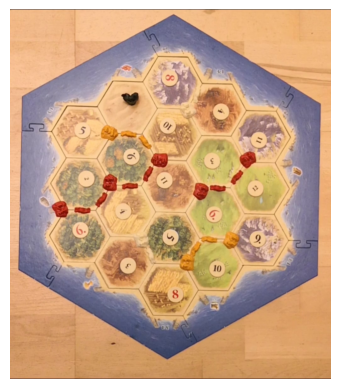

Frame extracted and saved as 'frame_100.jpg'


In [262]:
video_path = "catan1.mp4"
cap = cv2.VideoCapture(video_path)

frame_number = 100
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Read the frame
ret, frame = cap.read()

if ret:
    imshow(frame)
    cv2.imwrite("frame_100.jpg", frame)
    print("Frame extracted and saved as 'frame_100.jpg'")
else:
    print("Failed to extract frame.")

# Release the video capture object
cap.release()

### Settlement detection

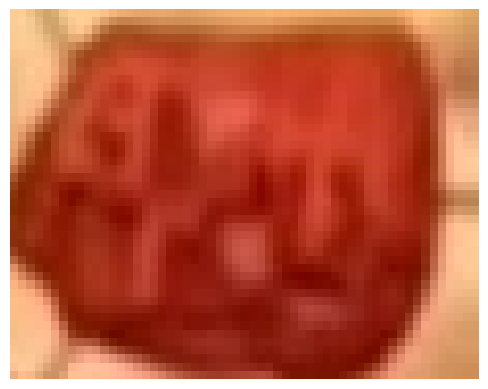

In [263]:
# Settlment template extracted from frame_100 using 'Paint' operations:)
settlement_template = cv2.imread("settlement_template.jpg", 1)
imshow(settlement_template)

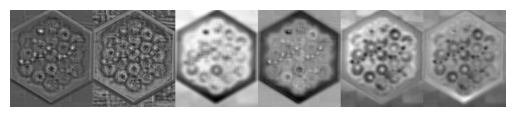

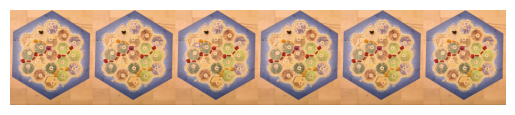

In [264]:
methods = [
    cv2.TM_CCOEFF,
    cv2.TM_CCOEFF_NORMED,
    cv2.TM_CCORR,
    cv2.TM_CCORR_NORMED,
    cv2.TM_SQDIFF,
    cv2.TM_SQDIFF_NORMED,
]

_, w, h = settlement_template.shape[::-1]

results_rgb = []
results_prob = []
for method in methods:
    _frame = frame.copy()
    # Apply template Matching
    res = cv2.matchTemplate(_frame, settlement_template, method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(_frame, top_left, bottom_right, (255, 0, 0), 2)

    results_rgb.append(_frame)
    results_prob.append((res - res.min()) * 255 / (res.max() - res.min()))

imshow(np.concatenate(results_prob, 1))
imshow(np.concatenate(results_rgb, 1))

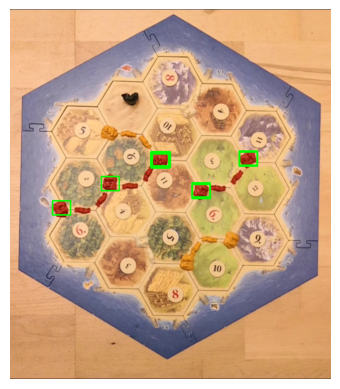

In [265]:
_frame = frame.copy()

res = cv2.matchTemplate(_frame, settlement_template, cv2.TM_CCORR_NORMED)
loc = np.where(res >= 0.95)
for pt in zip(*loc[::-1]):
    cv2.rectangle(_frame, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)

imshow(_frame)

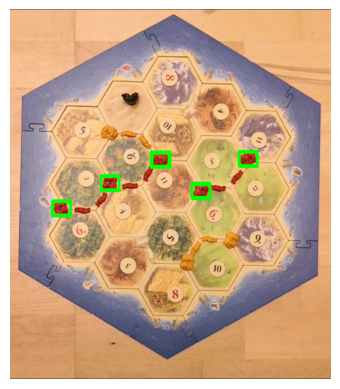

In [291]:
_frame = frame.copy()

res = cv2.matchTemplate(_frame, settlement_template, cv2.TM_SQDIFF_NORMED)
loc = np.where(res <= 0.12)
for pt in zip(*loc[::-1]):
    cv2.rectangle(_frame, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)

imshow(_frame)

### Number tokens detection

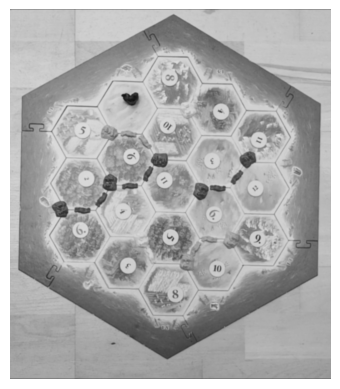

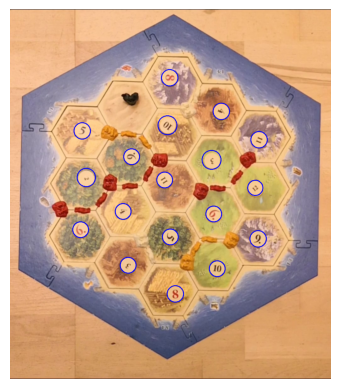

Number tokens count: 18


In [280]:
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(frame_gray, (5, 5), 0)
imshow(blurred)
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1.2, 40, 
                           param1=10, param2=45, minRadius=20, maxRadius=35)

img_result = frame.copy()
if circles is not None:
    circles = np.round(circles[0,]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(img_result, (x, y), r, (255, 0, 0), 2)  # Draw circle
    
imshow(img_result)
print("Number tokens count:", len(circles))